In [1]:
import os
import sys
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import network_utils as nuts
import physically_informed_loss_functions as pilf

In [2]:
dev_train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_device.xlsx')
train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_train.xlsx')
test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

dev_only_x = dev_train_df[['Time (min)', 'Temp (C)']]
dev_only_y = dev_train_df[['PCE', 'VocL', 'Jsc', 'FF']]
x_train = train_df[['Anneal_time', 'Anneal_temp',
                   'p1_fraction', 'p2_fraction', 'p3_fraction',
                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',

                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',

                   'p3_area_avg', 'p3_area_stdev', 'p3_filled_area_avg',
                   'p3_filled_area_stdev', 'p3_extent_avg', 'p3_extent_stdev',
                   'p3_MajorAL_avg', 'p3_MajorAL_stdev', 'p3_MinorAL_avg',
                   'p3_MinorAL_stdev', 'p3_Ecc_avg', 'p3_Ecc_stdev','p3_Orient_avg',
                   'p3_Orient_stdev', 'p3_Perim_avg', 'p3_Perim_stdev']]
y_train = train_df[['PCE', 'VocL', 'Jsc', 'FF']]

x_test = test_df[['Anneal_time', 'Anneal_temp',
                   'p1_fraction', 'p2_fraction', 'p3_fraction',
                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',

                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',

                   'p3_area_avg', 'p3_area_stdev', 'p3_filled_area_avg',
                   'p3_filled_area_stdev', 'p3_extent_avg', 'p3_extent_stdev',
                   'p3_MajorAL_avg', 'p3_MajorAL_stdev', 'p3_MinorAL_avg',
                   'p3_MinorAL_stdev', 'p3_Ecc_avg', 'p3_Ecc_stdev','p3_Orient_avg',
                   'p3_Orient_stdev', 'p3_Perim_avg', 'p3_Perim_stdev']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

After loading in the data and splitting it into our training and testing datasets, it's time for some curve fitting and hyper-parameter optimization. This notebook optimizes the LASSO fitting on the above datasets

First, we need to define some functions to train, optimize, and compare the LASSO regression results for predicting the 4 different OPV device parameters, PCE, V$_{OC}$, J$_{SC}$, and FF.

In [3]:
def round_up(n, decimals=1):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier


def round_down(n, decimals=1):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier


def plot_parity(labels, predictions):
    """
    This function calculates and plots the correlation values of labels and predictions.
    An $R^{2}$ coefficient is calculated from these and annotates the plot.
    """
    
    upper = round_up(max(max(labels), max(predictions)))
    lower = round_down(min(min(labels), min(predictions)))
    
    xlin = ylin = np.arange(upper, lower, 0.1)

    r2 = r2_score(labels, predictions)
    fig, ax = plt.subplots(figsize = (8,6))
    plt.scatter(labels, predictions)
    plt.plot(xlin, ylin, c = 'k')
    ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0, 0))
#     ax.set_xlim(lower, upper)
#     ax.set_ylim(lower, upper)
    ax.set_ylabel("Predictions")
    ax.set_xlabel("Ground Truth")
    
    return fig, ax


def mean_absolute_accuracy(labels, predictions):
    """
    This is a function to calculate the % accuracy of a batch of labels and 
    predictions made by a model.
    """
    
    accuracies = []
    for x, y in zip(predictions, labels):
        accuracy = np.abs(((y - x) / y)) * 100
        accuracies.append(accuracy)
        
    mean_accuracy = sum(accuracies)/len(accuracies)
        
    return mean_accuracy

def LASSO(x_fit, y_fit, x_pred, y_labels, alpha):
    """
    This function fits sklearn's lasso to data and returns train and test MSE, the
    final predicted labels, and the losses and coefficients of fit.
    """
    lasso = linear_model.Lasso(alpha = alpha, positive = False, tol = 1e-7, max_iter = 10000,
                               selection = 'random', random_state = 28)
    lasso.fit(x_fit, y_fit)

    y_train_pred = lasso.predict(x_fit)
    y_test_pred = lasso.predict(x_pred)

    train_mse = mean_squared_error(y_fit, y_train_pred)
    test_mse = mean_squared_error(y_labels, y_test_pred)
    test_accuracy = mean_absolute_accuracy(y_labels, y_test_pred)
    
    coeffs = lasso.coef_
    
    return y_test_pred, train_mse, test_mse, test_accuracy, coeffs


def LASSO_alpha_opt(x_fit, y_fit, x_pred, y_labels, lower, upper):
    """
    This function calls LASSO across a range of alphas and returns the best performing
    alpha, its index, and all the losses, and coefficients for each alpha.
    """
    
    alphas = np.logspace(lower, upper, 100)
    coeffs = {}
    train_errors = []
    test_errors = []

    best_alphas = []
    best_errors = []
    accuracies = []

    for i, a in enumerate(alphas):
        y_test_pred, train_mse, test_mse, test_accuracy, coeff = LASSO(x_fit, y_fit, x_pred, y_labels, a)
        
        coeffs[i] = coeff
        train_errors.append(train_mse)
        test_errors.append(test_mse)
        accuracies.append(test_accuracy)
        
        if i > 1:
            if test_errors[-1] <= test_errors[-2]:
                best_alphas.append(a)
                best_errors.append(test_mse)
                
            else:
                pass
        else:
            best_alphas.append(a)
            best_errors.append(test_mse)

    best_acc = min(accuracies)
    alpha_idx = accuracies.index(best_acc)
    best_alpha = alphas[alpha_idx]
    

    return train_errors, test_errors, best_alpha, alpha_idx, accuracies


def OPV_LASSO(x_train, y_train, x_test, y_test):
    """
    This function fits and optimizes 4 different sklearn LASSO instances to predict 4
    different OPV device performances, given the input information about the devices.
    """
    #Separate the labels by category for each dataset
    pce_train = y_train['PCE']
    pce_test = y_test['PCE']
    voc_train = y_train['VocL']
    voc_test = y_test['VocL']
    jsc_train = y_train['Jsc']
    jsc_test = y_test['Jsc']
    ff_train = y_train['FF']
    ff_test = y_test['FF']
    
    #Fit LASSO with a range of alphas for performance metric
    lower = -6
    upper = 6
    
    alphas = np.logspace(lower, upper, 100)
    
    pce_trn_err, pce_tst_err, pce_alpha, pce_idx, pce_accs  = LASSO_alpha_opt(x_train, pce_train,
                                                                     x_test, pce_test,
                                                                     lower = lower,
                                                                     upper = upper)
    voc_trn_err, voc_tst_err, voc_alpha, voc_idx, voc_accs = LASSO_alpha_opt(x_train, voc_train,
                                                                    x_test, voc_test,
                                                                    lower = lower,
                                                                    upper = upper)
    jsc_trn_err, jsc_tst_err, jsc_alpha, jsc_idx, jsc_accs = LASSO_alpha_opt(x_train, jsc_train,
                                                                    x_test, jsc_test,
                                                                    lower = lower,
                                                                    upper = upper)
    ff_trn_err, ff_tst_err, ff_alpha, ff_idx, ff_accs = LASSO_alpha_opt(x_train, ff_train,
                                                                x_test, ff_test,
                                                                lower = lower,
                                                                upper = upper)
    total_trn_err = []
    total_tst_err = []
    for pce1, pce2, voc1, voc2, jsc1, jsc2, ff1, ff2 in zip(pce_trn_err, pce_tst_err,
                                                            voc_trn_err, voc_tst_err,
                                                            jsc_trn_err, jsc_tst_err,
                                                            ff_trn_err, ff_tst_err):
        
        total_trn_err.append((pce1 + voc1 + jsc1 + ff1))
        total_tst_err.append((pce2 + voc2 + jsc2 + ff2))
    
    
    fig, ax = plt.subplots(figsize = (12, 8))
    plt.plot(alphas, total_trn_err, c = 'k', marker = '|', label = 'total train')
    plt.plot(alphas, total_tst_err, c = 'k', marker = '>', label = 'total test')
    ax.set_ylabel('MSE')
    ax.set_xlabel('alpha')
    plt.legend(loc = 'best')
    ax.set_xscale('log')
    plt.show()
    
    fig, ax = plt.subplots(figsize = (12, 8))
    plt.plot(alphas, pce_trn_err, c = 'k', marker = '|', label = 'pce train')
    plt.plot(alphas, pce_tst_err, c = 'k', marker = '>', label = 'pce test')
    plt.plot(alphas, voc_trn_err, c = 'r', marker = '|', label = 'voc train')
    plt.plot(alphas, voc_tst_err, c = 'r', marker = '>', label = 'voc test')
    plt.plot(alphas, jsc_trn_err, c = 'b', marker = '|', label = 'jsc train')
    plt.plot(alphas, jsc_tst_err, c = 'b', marker = '>', label = 'jsc test')
    plt.plot(alphas, ff_trn_err, c = 'g', marker = '|', label = 'ff train')
    plt.plot(alphas, ff_tst_err, c = 'g', marker = '>', label = 'ff test')
    ax.set_ylabel('MSE')
    ax.set_xlabel('alpha')
    plt.legend(loc = 'best')
    ax.set_xscale('log')
    plt.show()
    
    avg_acc = []
    for pce, voc, jsc, ff in zip(pce_accs, voc_accs, jsc_accs, ff_accs):
        
        avg_acc.append(((pce + voc + jsc + ff)/4))
    
    fig, ax = plt.subplots(figsize = (12,8))
    plt.plot(alphas, avg_acc, c = 'k', marker = '>', label = 'mean acc')
    plt.scatter(alphas[avg_acc.index(min(avg_acc))], min(avg_acc))
    plt.plot(alphas, pce_accs, c = 'r', marker = '|', label = 'pce acc')
    plt.plot(alphas, voc_accs, c = 'g', marker = '|', label = 'voc acc')
    plt.plot(alphas, jsc_accs, c = 'b', marker = '|', label = 'jsc acc')
    plt.plot(alphas, ff_accs, c = 'cyan', marker = '|', label = 'ff acc')
    ax.set_ylabel('Average Absolute Percent Error (%)')
    ax.set_xlabel('alpha')
    plt.legend(loc = 'best')
    ax.set_xscale('log')
    plt.show()
    
    #For the best alpha for each LASSO, final fit and predict test labels
    pce_pred, pce_train_mse, pce_test_mse, pce_acc, pce_coeffs = LASSO(x_train, pce_train, x_test,
                                                              pce_test, pce_alpha)
    voc_pred, voc_train_mse, voc_test_mse, voc_acc, voc_coeffs = LASSO(x_train, voc_train, x_test,
                                                              voc_test, voc_alpha)
    jsc_pred, jsc_train_mse, jsc_test_mse, jsc_acc, jsc_coeffs = LASSO(x_train, jsc_train, x_test,
                                                              jsc_test, jsc_alpha)
    ff_pred, ff_train_mse, ff_test_mse, ff_acc, ff_coeffs = LASSO(x_train,ff_train, x_test,
                                                          ff_test, ff_alpha)
    
    print(f"PCE coefficients: {len(pce_coeffs)}")
    print(f"Voc coefficients: {len(voc_coeffs)}")
    print(f"Jsc coefficients: {len(jsc_coeffs)}")
    print(f"FF coefficients: {len(ff_coeffs)}")
    
    nuts.plot_OPV_parity(pce_test, pce_pred, voc_test, voc_pred, jsc_test, jsc_pred, ff_test, ff_pred)
    
    
    OPV_LASSO_dict = {
        'pce' : [pce_pred, pce_train_mse, pce_test_mse, pce_coeffs, pce_accs],
        'voc' : [voc_pred, voc_train_mse, voc_test_mse, voc_coeffs, voc_accs],
        'jsc' : [jsc_pred, jsc_train_mse, jsc_test_mse, jsc_coeffs, jsc_accs],
        'ff' : [jsc_pred, jsc_train_mse, jsc_test_mse, jsc_coeffs, ff_accs]
    }
    
    return OPV_LASSO_dict



/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007015234481425089, tolerance: 3.5831951974778366e-07
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009090666752588008, tolerance: 3.5831951974778366e-07
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011751149887617122, tolerance: 3.5831951974778366e-07
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Convergence

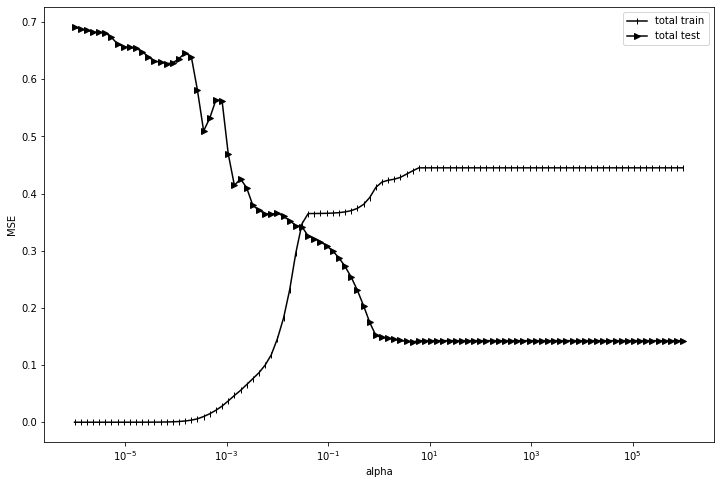

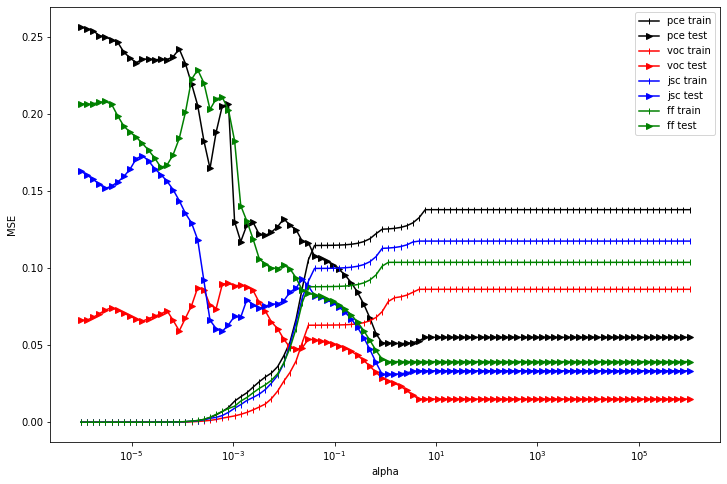

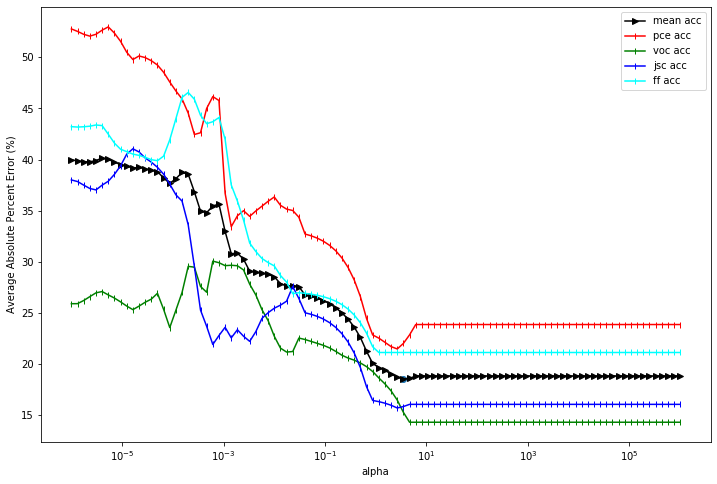

PCE coefficients: 53
Voc coefficients: 53
Jsc coefficients: 53
FF coefficients: 53


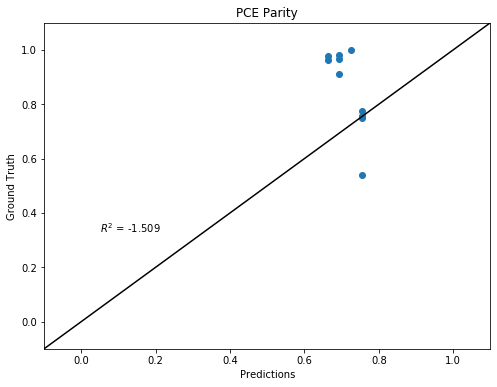

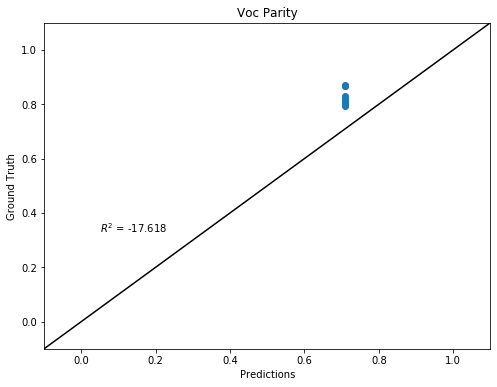

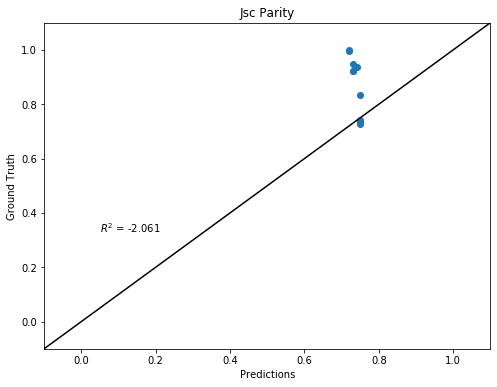

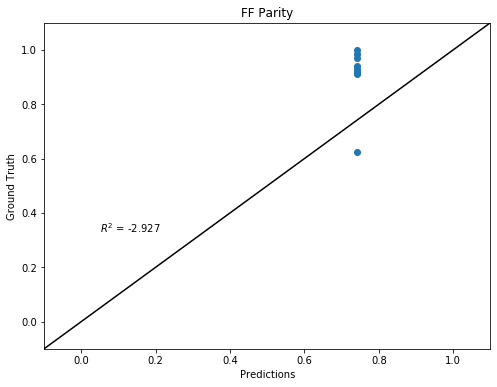

In [4]:
results = OPV_LASSO(x_train, y_train, x_test, y_test)

In [5]:
params = {
    'alpha' : np.logspace(-5, -1, 500),
    'positive' : [False],
    'tol' : [1e-5, 1e-4],
    'max_iter' : [10000],
    'selection' : ['random'],
    'random_state' : [28]
}

pce_lasso = GridSearchCV(linear_model.Lasso(), params)
voc_lasso = GridSearchCV(linear_model.Lasso(), params)
jsc_lasso = GridSearchCV(linear_model.Lasso(), params)
ff_lasso = GridSearchCV(linear_model.Lasso(), params)

In [6]:
pce_lasso.fit(x_train, y_train['PCE'])
voc_lasso.fit(x_train, y_train['VocL'])
jsc_lasso.fit(x_train, y_train['Jsc'])
ff_lasso.fit(x_train, y_train['FF'])

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035685903334825293, tolerance: 3.342676816795589e-05
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002072256803588282, tolerance: 3.084196014923341e-05
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001989671035911183, tolerance: 3.0388617500040475e-05
  positive)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarn

GridSearchCV(cv=None, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-05, 1.01862899e-05, 1.03760502e-05, 1.05693455e-05,
       1.07662418e-...
       8.16250851e-02, 8.31456781e-02, 8.46945981e-02, 8.62723729e-02,
       8.78795401e-02, 8.95166472e-02, 9.11842520e-02, 9.28829225e-02,
       9.46132376e-02, 9.63757866e-02, 9.81711702e-02, 1.00000000e-01]),
                         'max_iter': [10000], 'positive': [False],
                         'random_state': [28], 'selection': ['random'],
                         'tol': [1e-05, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             

In [7]:
pce_params = pce_lasso.best_params_
voc_params = voc_lasso.best_params_
jsc_params = jsc_lasso.best_params_
ff_params = ff_lasso.best_params_

print(pce_params)
print(voc_params)
print(jsc_params)
print(ff_params)

{'alpha': 0.04047756965997318, 'max_iter': 10000, 'positive': False, 'random_state': 28, 'selection': 'random', 'tol': 0.0001}
{'alpha': 0.004337850187558989, 'max_iter': 10000, 'positive': False, 'random_state': 28, 'selection': 'random', 'tol': 1e-05}
{'alpha': 0.1, 'max_iter': 10000, 'positive': False, 'random_state': 28, 'selection': 'random', 'tol': 0.0001}
{'alpha': 0.1, 'max_iter': 10000, 'positive': False, 'random_state': 28, 'selection': 'random', 'tol': 0.0001}


In [8]:
pce_preds = pce_lasso.predict(x_test)
voc_preds = voc_lasso.predict(x_test)
jsc_preds = jsc_lasso.predict(x_test)
ff_preds = ff_lasso.predict(x_test)

In [9]:
%autoreload

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(pce_preds, y_test['PCE'])
pce_r2 = r2_score(pce_preds, y_test['PCE'])
pce_mape = mape.forward(pce_preds, y_test['PCE'])

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(voc_preds, y_test['VocL'])
voc_r2 = r2_score(voc_preds, y_test['VocL'])
voc_mape = mape.forward(voc_preds, y_test['VocL'])

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(jsc_preds, y_test['Jsc'])
jsc_r2 = r2_score(jsc_preds, y_test['Jsc'])
jsc_mape = mape.forward(jsc_preds, y_test['Jsc'])

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(ff_preds, y_test['FF'])
ff_r2 = r2_score(ff_preds, y_test['FF'])
ff_mape = mape.forward(ff_preds, y_test['FF'])

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.10749379751311142, mape = 32.7219948836602, r2 = -1.9891134432975814
mse = 0.07203694815835245, mape = 26.757759117178626, r2 = -1.3505306455392527
mse = 0.07664065677558543, mape = 24.327121885808232, r2 = -1.5538684644640859
mse = 0.07788303963352564, mape = 26.551164428189445, r2 = -1.8640016638349266


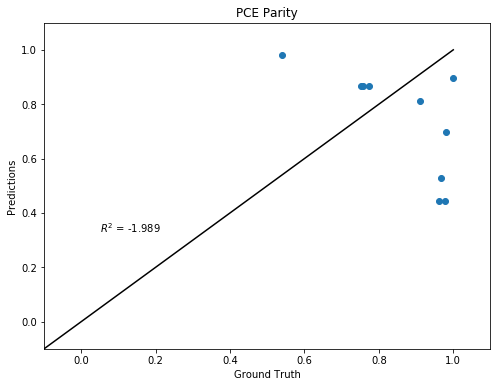

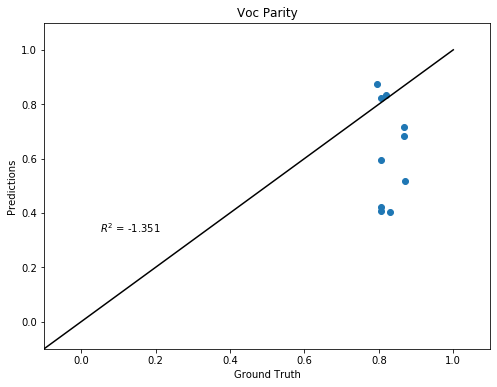

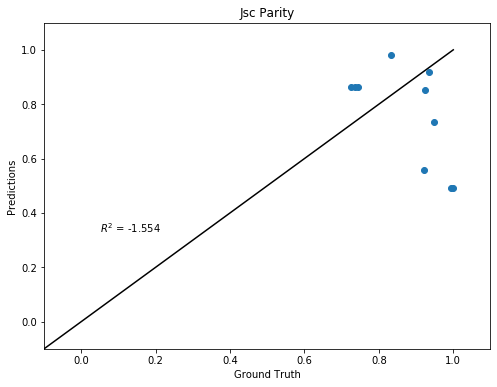

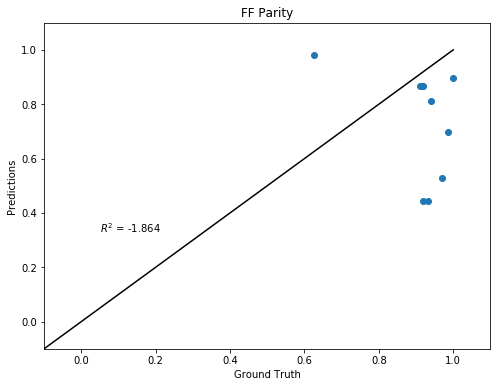

In [10]:
xlin = ylin = np.arange(-2, 2, 1)

r2 = r2_score(pce_preds, y_test['PCE'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(voc_preds, y_test['VocL'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['VocL'], voc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(jsc_preds, y_test['Jsc'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['Jsc'], jsc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(ff_preds, y_test['FF'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['FF'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('FF Parity')
plt.show()

# Device data only regression

In [20]:
params = {
    'alpha' : np.logspace(-3, 1, 500),
    'positive' : [False],
    'tol' : [1e-5, 1e-4],
    'max_iter' : [10000],
    'selection' : ['random'],
    'random_state' : [28]
}

pce_lasso = GridSearchCV(linear_model.Lasso(), params)
voc_lasso = GridSearchCV(linear_model.Lasso(), params)
jsc_lasso = GridSearchCV(linear_model.Lasso(), params)
ff_lasso = GridSearchCV(linear_model.Lasso(), params)

pce_lasso.fit(dev_only_x, dev_only_y['PCE'])
voc_lasso.fit(dev_only_x, dev_only_y['VocL'])
jsc_lasso.fit(dev_only_x, dev_only_y['Jsc'])
ff_lasso.fit(dev_only_x, dev_only_y['FF'])

GridSearchCV(cv=None, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-03, 1.01862899e-03, 1.03760502e-03, 1.05693455e-03,
       1.07662418e-...
       8.16250851e+00, 8.31456781e+00, 8.46945981e+00, 8.62723729e+00,
       8.78795401e+00, 8.95166472e+00, 9.11842520e+00, 9.28829225e+00,
       9.46132376e+00, 9.63757866e+00, 9.81711702e+00, 1.00000000e+01]),
                         'max_iter': [10000], 'positive': [False],
                         'random_state': [28], 'selection': ['random'],
                         'tol': [1e-05, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             

In [21]:
pce_params = pce_lasso.best_params_
voc_params = voc_lasso.best_params_
jsc_params = jsc_lasso.best_params_
ff_params = ff_lasso.best_params_

print(pce_params)
print(voc_params)
print(jsc_params)
print(ff_params)

{'alpha': 1.9345196537440443, 'max_iter': 10000, 'positive': False, 'random_state': 28, 'selection': 'random', 'tol': 1e-05}
{'alpha': 0.8747496301554415, 'max_iter': 10000, 'positive': False, 'random_state': 28, 'selection': 'random', 'tol': 1e-05}
{'alpha': 3.4282314937339673, 'max_iter': 10000, 'positive': False, 'random_state': 28, 'selection': 'random', 'tol': 1e-05}
{'alpha': 0.001, 'max_iter': 10000, 'positive': False, 'random_state': 28, 'selection': 'random', 'tol': 1e-05}


In [22]:
pce_preds = pce_lasso.predict(x_test[['Anneal_time', 'Anneal_temp']])
voc_preds = voc_lasso.predict(x_test[['Anneal_time', 'Anneal_temp']])
jsc_preds = jsc_lasso.predict(x_test[['Anneal_time', 'Anneal_temp']])
ff_preds = ff_lasso.predict(x_test[['Anneal_time', 'Anneal_temp']])

%autoreload

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(pce_preds, y_test['PCE'])
pce_r2 = r2_score(pce_preds, y_test['PCE'])
pce_mape = mape.forward(pce_preds, y_test['PCE'])

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(voc_preds, y_test['VocL'])
voc_r2 = r2_score(voc_preds, y_test['VocL'])
voc_mape = mape.forward(voc_preds, y_test['VocL'])

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(jsc_preds, y_test['Jsc'])
jsc_r2 = r2_score(jsc_preds, y_test['Jsc'])
jsc_mape = mape.forward(jsc_preds, y_test['Jsc'])

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(ff_preds, y_test['FF'])
ff_r2 = r2_score(ff_preds, y_test['FF'])
ff_mape = mape.forward(ff_preds, y_test['FF'])

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.06237780411687539, mape = 25.43718410597608, r2 = 0.0
mse = 0.0031331146080494894, mape = 5.720882468866961, r2 = 0.0
mse = 0.03139884903057691, mape = 15.467327051608978, r2 = 0.0
mse = 0.031517132946129844, mape = 18.073382371903605, r2 = -16.59892220145237


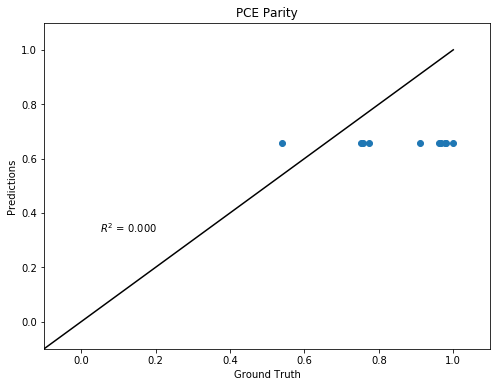

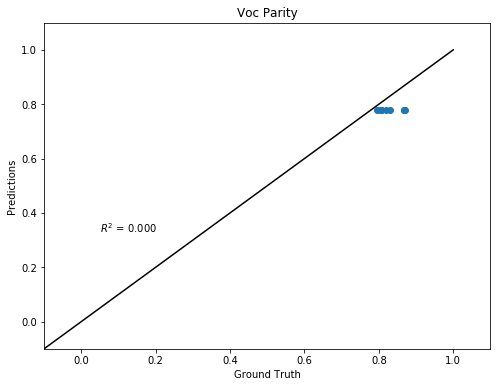

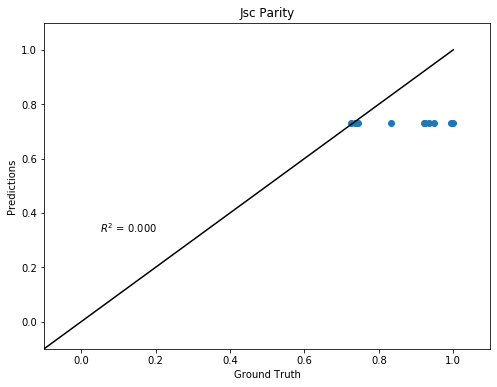

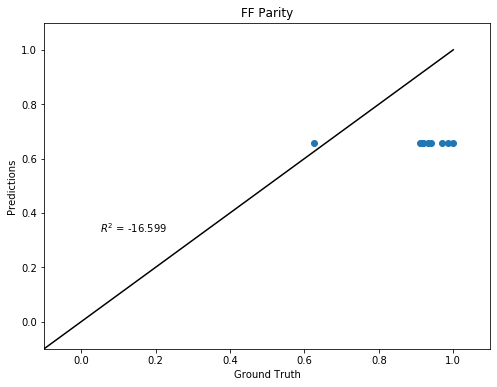

In [23]:
xlin = ylin = np.arange(-2, 2, 1)

r2 = r2_score(pce_preds, y_test['PCE'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(voc_preds, y_test['VocL'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['VocL'], voc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(jsc_preds, y_test['Jsc'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['Jsc'], jsc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(ff_preds, y_test['FF'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['FF'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('FF Parity')
plt.show()